### Partie 2 : Analyse exploratoire des données et clustering

In [100]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy
import math
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
from math import exp, sqrt, pi
from scipy.stats import chi2_contingency, pearsonr
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [5]:
complete = pd.read_csv('complete.csv')
complete = complete.drop(columns=['Unnamed: 0'])

complete.head()

,Zone,Disponibilité alimentaire volailles (Kcal/personne/jour),Disponibilité de protéines (g/personne/jour),Importations volailles (milliers tonnes),Production volailles (milliers tonnes),Disponibilité alimentaire totale (Kcal/personne/jour),PIB / Habitant ($),Stabilité politique (indice),Evolution Pop % (2000-2017)
0,Afghanistan,5.0,0.54,29.0,28.0,2266.0,2058.4,-2.80,75.0
1,Afrique du Sud,143.0,14.11,514.0,1667.0,2902.0,13860.3,-0.28,27.0
2,Albanie,85.0,6.26,38.0,13.0,3314.0,12771.0,0.38,-8.0
3,Algérie,22.0,1.97,2.0,275.0,3402.0,11737.4,-0.92,33.0
4,Allemagne,71.0,7.96,842.0,1514.0,3551.0,53071.5,0.59,2.0


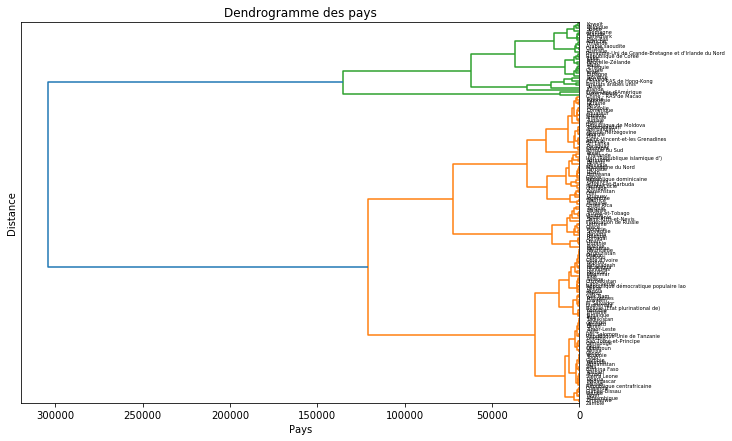

In [7]:
# Réalisation d'un dendogramme en fonction des variables quantitatives du dataframe 'complete'

df = complete

quantitative_vars = ['Disponibilité alimentaire volailles (Kcal/personne/jour)',
                     'Disponibilité de protéines (g/personne/jour)',
                     'Importations volailles (milliers tonnes)',
                     'Production volailles (milliers tonnes)',
                     'Disponibilité alimentaire totale (Kcal/personne/jour)',
                     'PIB / Habitant ($)',
                     'Stabilité politique (indice)',
                     'Evolution Pop % (2000-2017)']

data_for_dendrogram = df[quantitative_vars]

# Calcul de la matrice de distance entre les observations et
# réalisation d'un clustering hiérarchique sur ces distances pour former le dendrogramme
# La méthode de liaison ward minimise l'augmentation totale de la variance intra-cluster
distance_matrix = hierarchy.distance.pdist(data_for_dendrogram, metric='euclidean')
linkage_matrix = hierarchy.linkage(distance_matrix, method='ward')

plt.figure(figsize=(10, 7))
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=df['Zone'].tolist(), orientation='left')
plt.title('Dendrogramme des pays')
plt.xlabel('Pays')
plt.ylabel('Distance')
plt.show()

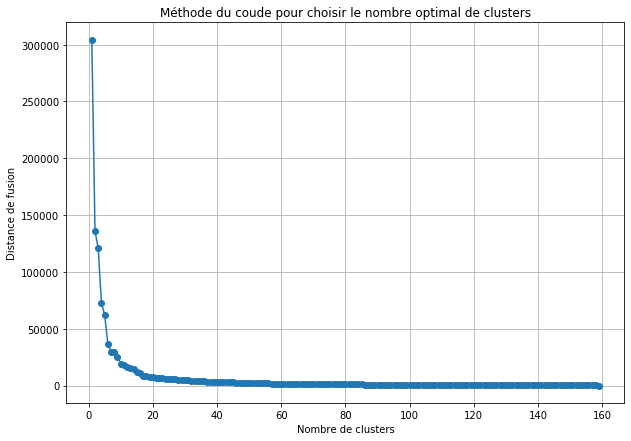

In [46]:
# Utilisation de la méthode du coude pour déterminer le nombre de clusters

# La méthode du coude vous aide à identifier le nombre optimal de clusters en examinant
# comment la distance de fusion change lorsque vous augmentez le nombre de clusters.

# Extraire les distances de fusion
distances = linkage_matrix[:, 2]
distances = sorted(distances, reverse=True)

# Tracer les distances
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(distances) + 1), distances, marker='o')
plt.title('Méthode du coude pour choisir le nombre optimal de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Distance de fusion')
plt.grid(True)
plt.show()

In [71]:
# à la lecture du graphique et la méthode du coude utilisé, on peut supposer
# que le nombre optimal de clusters est 5

# Appliquons la méthode des k-means pour attribuer à chaque pays son cluster
# random_state=42 sert à s'assurer que l'algorithme k-means donnera les mêmes résultats chaque fois qu'il est exécuté avec ces paramètres, ce qui facilite le débogage, la comparaison des modèles et la collaboration avec d'autres
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X_scaled)+1

# Ajouter les clusters au DataFrame original
df['Cluster'] = clusters

df.head()

,Zone,Disponibilité alimentaire volailles (Kcal/personne/jour),Disponibilité de protéines (g/personne/jour),Importations volailles (milliers tonnes),Production volailles (milliers tonnes),Disponibilité alimentaire totale (Kcal/personne/jour),PIB / Habitant ($),Stabilité politique (indice),Evolution Pop % (2000-2017),Cluster
0,Afghanistan,5.0,0.54,29.0,28.0,2266.0,2058.4,-2.80,75.0,2
1,Afrique du Sud,143.0,14.11,514.0,1667.0,2902.0,13860.3,-0.28,27.0,3
2,Albanie,85.0,6.26,38.0,13.0,3314.0,12771.0,0.38,-8.0,1
3,Algérie,22.0,1.97,2.0,275.0,3402.0,11737.4,-0.92,33.0,2
4,Allemagne,71.0,7.96,842.0,1514.0,3551.0,53071.5,0.59,2.0,3


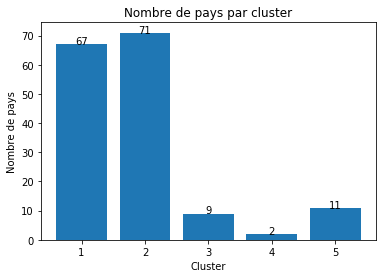

In [73]:
# Compter le nombre de pays par cluster
cluster_counts = df['Cluster'].value_counts().sort_index()

# Créer un graphique en barres
plt.bar(cluster_counts.index, cluster_counts.values)

# Ajouter les valeurs au-dessus de chaque barre
for index, value in cluster_counts.items():
    plt.text(index, value, str(value), ha='center')  # ha='center' centre le texte

# Ajouter des titres et des labels
plt.title('Nombre de pays par cluster')
plt.xlabel('Cluster')
plt.ylabel('Nombre de pays')
plt.xticks(range(1, len(cluster_counts.index) + 1))  # Assurez-vous que les clusters sont étiquetés de 1 à n
plt.show()

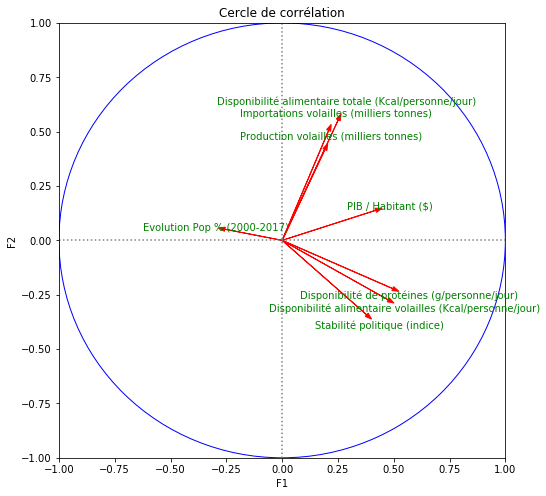

In [74]:
# Création d'un cercle de corrélation
# Standardiser les données
scaler = StandardScaler()
data_std = scaler.fit_transform(df[quantitative_vars])

# Ajuster l'ACP
pca = PCA()
data_pca = pca.fit_transform(data_std)

# Créer le cercle de corrélation
plt.figure(figsize=(8, 8))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.hlines(0, -1, 1, colors='grey', linestyles='dotted')
plt.vlines(0, -1, 1, colors='grey', linestyles='dotted')

# Ajouter les vecteurs
for i in range(len(quantitative_vars)):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], color='r',  head_width=0.02, head_length=0.03)
    plt.text(pca.components_[0, i]*1.15, pca.components_[1, i]*1.15, quantitative_vars[i], color='g', ha='center', va='center')

# Ajouter le cercle
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
plt.gca().add_artist(circle)

# Tracer le cercle
plt.xlabel('F1')
plt.ylabel('F2')
plt.title('Cercle de corrélation')
plt.show()

Observations :
    
    F1 (axe horizontal) :
        Les variables avec une valeur positive élevée sur l'axe F1 (comme "PIB / Habitant", "Disponibilité en protéines", "Disponibilité alimentaire volailles" et "Stabilité politique") sont fortement corrélées positivement avec cette composante. Cela signifie que les pays ayant des valeurs élevées pour ces variables auront également des scores élevés sur la composante F1.
        Les variables avec une valeur négative sur l'axe F1 (comme "Evolution Pop %") sont corrélées négativement avec cette composante. Cela signifie que les pays avec des valeurs élevées pour ces variables auront des scores plus faibles sur la composante F1.

    F2 (axe vertical) :
        Les variables avec une valeur positive élevée sur l'axe F2 (comme "Disponibilité alimentaire totale", "Importations volailles" et "Production volailles") sont fortement corrélées positivement avec cette composante. Les pays ayant des valeurs élevées pour ces variables auront également des scores élevés sur la composante F2.
        Les variables avec une valeur négative sur l'axe F2 (comme "Disponibilité en protéines", "Disponibilité alimentaire volailles" et "Stabilité politique") sont corrélées négativement avec cette composante. Les pays avec des valeurs élevées pour ces variables auront des scores plus faibles sur la composante F2.

In [75]:
# Examiner la part de la variance expliquée par ces composantes pour
# évaluer à quel point elles représentent bien l'ensemble des données

# Sélectionner les colonnes quantitatives
data_quanti = df[quantitative_vars]

# Ajuster le PCA
pca = PCA()
pca.fit(data_quanti)

# La part de la variance expliquée par chaque composante
explained_variance_ratio = pca.explained_variance_ratio_

# Afficher la part de la variance expliquée par les deux premières composantes
print("Part de la variance expliquée par la première composante :", explained_variance_ratio[0])
print("Part de la variance expliquée par la deuxième composante :", explained_variance_ratio[1])

Part de la variance expliquée par la première composante : 0.9881440665969632
Part de la variance expliquée par la deuxième composante : 0.01022497253852327


Observations :  
 
    Première Composante Principale (PC1): Cette composante capte la majeure partie de l'information dans vos données, soit environ 98.8%. Elle représente les variations communes entre les variables de votre jeu de données. Dans la plupart des cas, cela signifie qu'il y a une forte corrélation entre plusieurs des variables dans votre ensemble de données, et la PC1 capture cette corrélation commune.

    Deuxième Composante Principale (PC2): Cette composante capte une partie beaucoup plus petite de l'information dans vos données, soit environ 1.02%. Cela peut indiquer que la PC2 capture des variations qui sont perpendiculaires à celles capturées par la PC1, mais ces variations sont beaucoup moins importantes en termes de la quantité totale de l'information qu'elles représentent.

    Importance Relative des Composantes: Étant donné que la première composante explique une part si élevée de la variance, cela signifie que vous pouvez souvent résumer votre jeu de données en utilisant uniquement cette composante, sans perdre beaucoup d'information. Cela peut être très utile pour la visualisation ou si vous voulez réduire la dimensionnalité de vos données sans perdre beaucoup d'informations pertinentes.

En conclusion, ces résultats indiquent probablement que la plupart de vos variables sont fortement corrélées les unes avec les autres, et que la plupart des informations peuvent être capturées par une seule mesure composite (la première composante principale). La deuxième composante principale, bien qu'orthogonale à la première, n'ajoute que peu d'information supplémentaire.

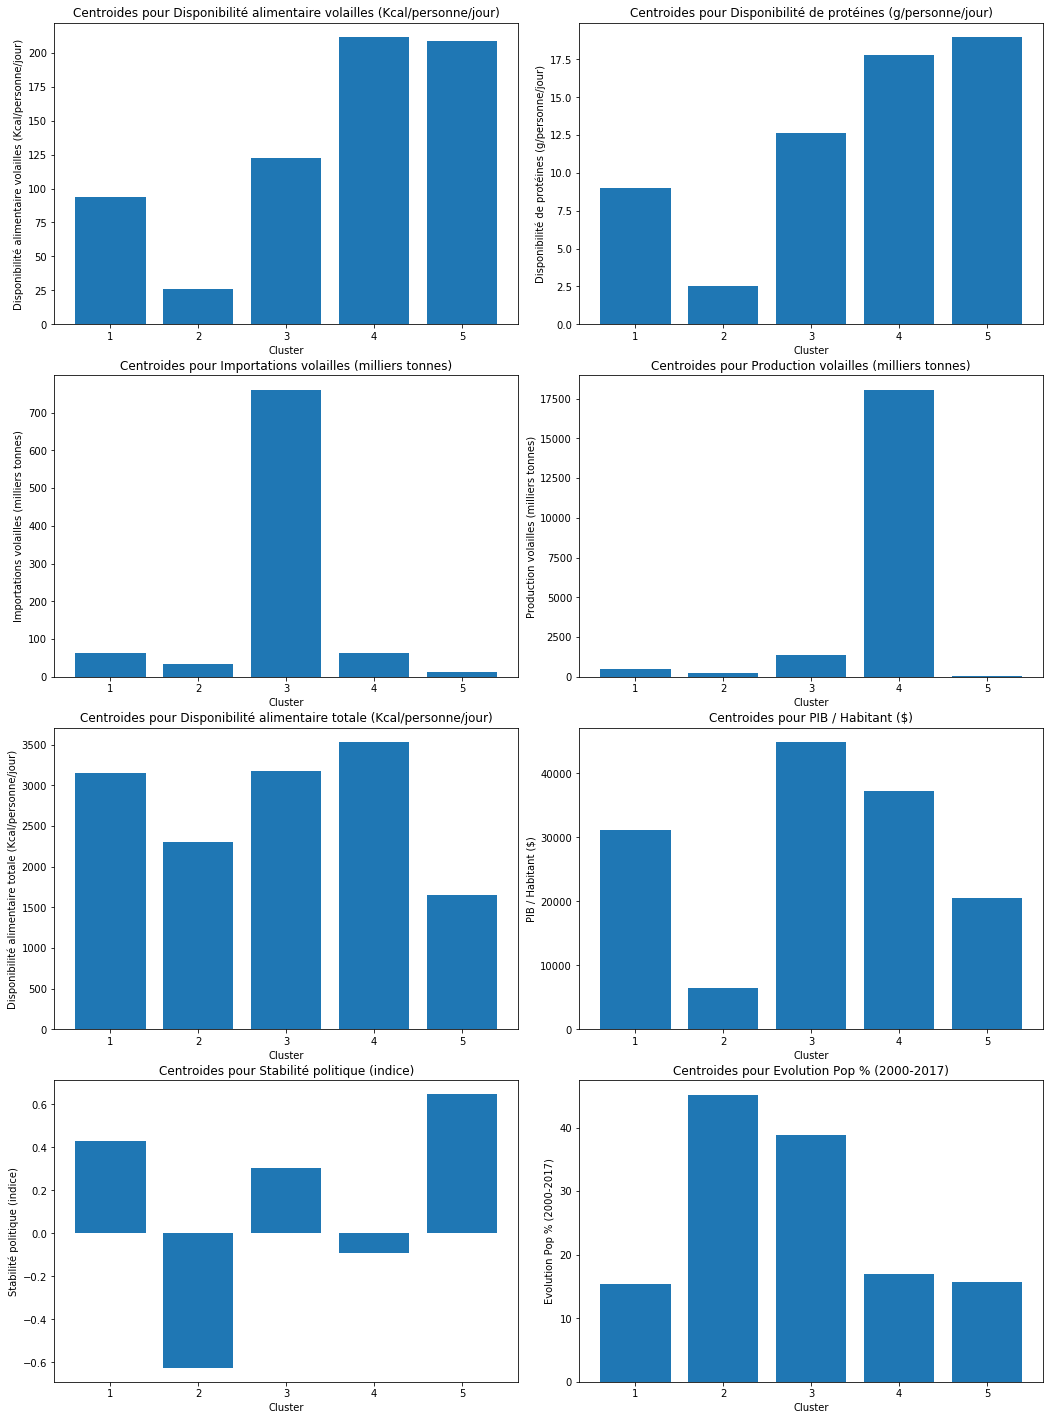

In [96]:
# Utilisation des centroïdes pour visualiser les clusters à retenir

def plot_centroids(centroids):
    num_variables = len(centroids.keys())
    clusters = range(1, len(centroids[list(centroids.keys())[0]]) + 1)

    # Définir le nombre de lignes et de colonnes
    num_rows = 4
    num_cols = 2

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 20))
    fig.tight_layout(pad=3.0)

    for i, (variable_name, values) in enumerate(centroids.items()):
        row, col = divmod(i, num_cols)
        axs[row, col].bar(clusters, values)
        axs[row, col].set_xlabel('Cluster')
        axs[row, col].set_ylabel(variable_name)
        axs[row, col].set_title(f'Centroides pour {variable_name}')

    # Supprimer les sous-graphiques vides si le nombre de variables est moins que num_rows * num_cols
    for i in range(num_variables, num_rows * num_cols):
        row, col = divmod(i, num_cols)
        fig.delaxes(axs[row, col])

    plt.show()
    

# Récupérer les centroides
centroides_scaled = kmeans.cluster_centers_

# Inverser la normalisation si nécessaire
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[quantitative_vars])  # variables quantitatives
centroides = scaler.inverse_transform(centroides_scaled)

# Convertir en DataFrame pour faciliter l'analyse
centroides_df = pd.DataFrame(centroides, columns=quantitative_vars)
    
plot_centroids(centroides_df)

Observations : 

    Le Cluster 2 pourrait représenter des pays en développement ou avec des économies 
    plus faibles.
    Le Cluster 3 pourrait représenter des pays développés avec une forte importation de  
    volailles.
    Le Cluster 4 pourrait inclure de grands producteurs de volailles.

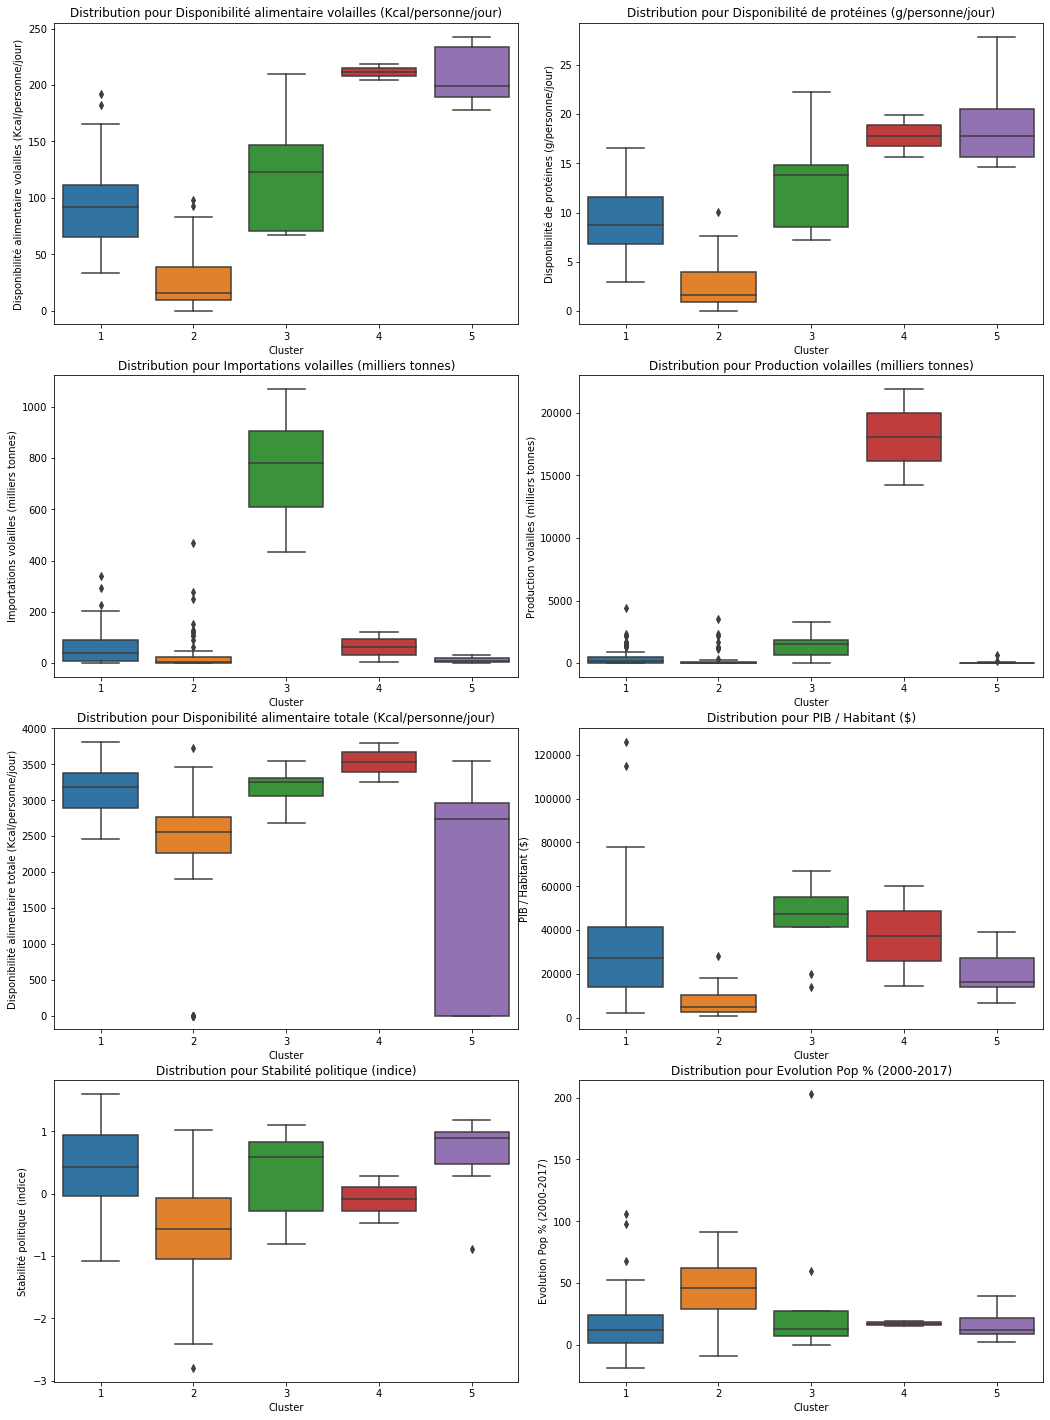

In [102]:
# Visualisons les données des clusters avec des graphiques de type 'boite à moustaches'

def plot_boxplots(df, columns_to_plot):
    num_variables = len(columns_to_plot)
    
    # Définir le nombre de lignes et de colonnes
    num_cols = 2
    num_rows = math.ceil(num_variables / num_cols) # Calculer le nombre de lignes en fonction du nombre de colonnes et de variables

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 20))
    fig.tight_layout(pad=3.0)

    for i, variable_name in enumerate(columns_to_plot):
        row, col = divmod(i, num_cols)
        
        # Créer le boxplot pour chaque variable, groupé par 'Cluster'
        sns.boxplot(x='Cluster', y=variable_name, data=df, ax=axs[row, col])
        axs[row, col].set_xlabel('Cluster')
        axs[row, col].set_ylabel(variable_name)
        axs[row, col].set_title(f'Distribution pour {variable_name}')

    # Supprimer les sous-graphiques vides si le nombre de variables est moins que num_rows * num_cols
    for i in range(num_variables, num_rows * num_cols):
        row, col = divmod(i, num_cols)
        fig.delaxes(axs[row, col])

    plt.show()

columns_to_plot = [
    'Disponibilité alimentaire volailles (Kcal/personne/jour)',
    'Disponibilité de protéines (g/personne/jour)',
    'Importations volailles (milliers tonnes)',
    'Production volailles (milliers tonnes)',
    'Disponibilité alimentaire totale (Kcal/personne/jour)',
    'PIB / Habitant ($)',
    'Stabilité politique (indice)',
    'Evolution Pop % (2000-2017)'
]

plot_boxplots(df, columns_to_plot)